In [ ]:
# -*- coding: utf-8 -*-
"""Semi-Supervised Mango Leaf Classification with Pseudo-Labeling"""

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download aryashah2k/mango-leaf-disease-dataset

import os
import numpy as np
import pandas as pd
import random
import shutil
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
import matplotlib.pyplot as plt

"""# Step 1: Split Data into Train (80%), Validation (10%), Test (10%)"""

import kagglehub

# Paths
source_dir = kagglehub.dataset_download("aryashah2k/mango-leaf-disease-dataset")
base_dir = '/content/semi_supervised_data/'

# Create main directories
for split in ['train', 'validation', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

classes = [c for c in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, c))]

# Create class subdirectories
for cls in classes:
    for split in ['train', 'validation', 'test']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Split data: 80% train, 10% validation, 10% test
def split_data():
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        if os.path.isdir(class_dir):
            images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(images)

            total = len(images)
            train_size = int(0.8 * total)
            val_size = int(0.1 * total)

            train_images = images[:train_size]
            val_images = images[train_size:train_size + val_size]
            test_images = images[train_size + val_size:]

            # Copy images
            for image in train_images:
                shutil.copy2(os.path.join(class_dir, image),
                           os.path.join(base_dir, 'train', cls, image))
            for image in val_images:
                shutil.copy2(os.path.join(class_dir, image),
                           os.path.join(base_dir, 'validation', cls, image))
            for image in test_images:
                shutil.copy2(os.path.join(class_dir, image),
                           os.path.join(base_dir, 'test', cls, image))

split_data()
print("✅ Data split into 80% train, 10% validation, 10% test")

"""# Step 2: Split Train Data into Labeled (25%) and Unlabeled (75%)"""

labeled_dir = '/content/semi_supervised_data/labeled/'
unlabeled_dir = '/content/semi_supervised_data/unlabeled/'

# Create directories
for cls in classes:
    os.makedirs(os.path.join(labeled_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(unlabeled_dir, cls), exist_ok=True)

def split_labeled_unlabeled():
    train_dir = os.path.join(base_dir, 'train')

    for cls in classes:
        class_dir = os.path.join(train_dir, cls)
        images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        labeled_size = int(0.25 * len(images))
        labeled_images = images[:labeled_size]
        unlabeled_images = images[labeled_size:]

        # Copy labeled images
        for image in labeled_images:
            shutil.copy2(os.path.join(class_dir, image),
                       os.path.join(labeled_dir, cls, image))

        # Copy unlabeled images
        for image in unlabeled_images:
            shutil.copy2(os.path.join(class_dir, image),
                       os.path.join(unlabeled_dir, cls, image))

split_labeled_unlabeled()
print("✅ Train data split into 25% labeled and 75% unlabeled")

# Print dataset statistics
print("\n📊 Dataset Statistics:")
for split_name, split_path in [('Labeled', labeled_dir),
                                ('Unlabeled', unlabeled_dir),
                                ('Validation', os.path.join(base_dir, 'validation')),
                                ('Test', os.path.join(base_dir, 'test'))]:
    total = sum([len(os.listdir(os.path.join(split_path, cls))) for cls in classes])
    print(f"{split_name}: {total} images")

"""# Step 3: Load Datasets"""

img_size = (224, 224)
batch_size = 32

# Load labeled dataset
labeled_dataset = image_dataset_from_directory(
    labeled_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)

# Load validation dataset
val_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)

class_names = labeled_dataset.class_names
num_classes = len(class_names)
print(f"\n🏷️ Classes: {class_names}")

"""# Step 4: Preprocess Datasets"""

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

labeled_dataset = labeled_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)



cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
Using Colab cache for faster access to the 'mango-leaf-disease-dataset' dataset.
✅ Data split into 80% train, 10% validation, 10% test
✅ Train data split in

In [ ]:
"""# Step 5: Build Model"""
from keras import regularizers
from keras.layers import MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Conv2D, Dropout, Rescaling, Input
from keras.models import Sequential
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze base model
    base_model.trainable = False

    # Create model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.016)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.016)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = build_model()

"""# Step 6: Train on Labeled Data (30 Epochs)"""

print("\n🚀 Phase 1: Training on Labeled Data (30 epochs)")

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history_labeled = model.fit(
    labeled_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)


# Evaluate on validation set
test_loss, test_acc = model.evaluate(test_dataset)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Phase 1: Training on Labeled Data (30 epochs)
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 520ms/step - accuracy: 0.1441 - loss: 9.3026 - val_accuracy: 0.3800 - val_loss: 6.3436 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.3043 - loss: 5.7564 - val_accuracy: 0.4400 - val_loss: 4.1726 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.3626 - loss: 3.9282 - val_accuracy: 0.6500 - val_loss: 3.0606 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.4472 - loss: 2.9887 - val_accuracy: 0.6600 - val_loss: 2.4884 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.5302 - loss: 2.4305 - val_accuracy: 0.6450 - val_loss: 2.1298 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.5985 - loss: 2.1441 - val_accuracy: 0.7325 - val_loss: 1.8927 - learning_

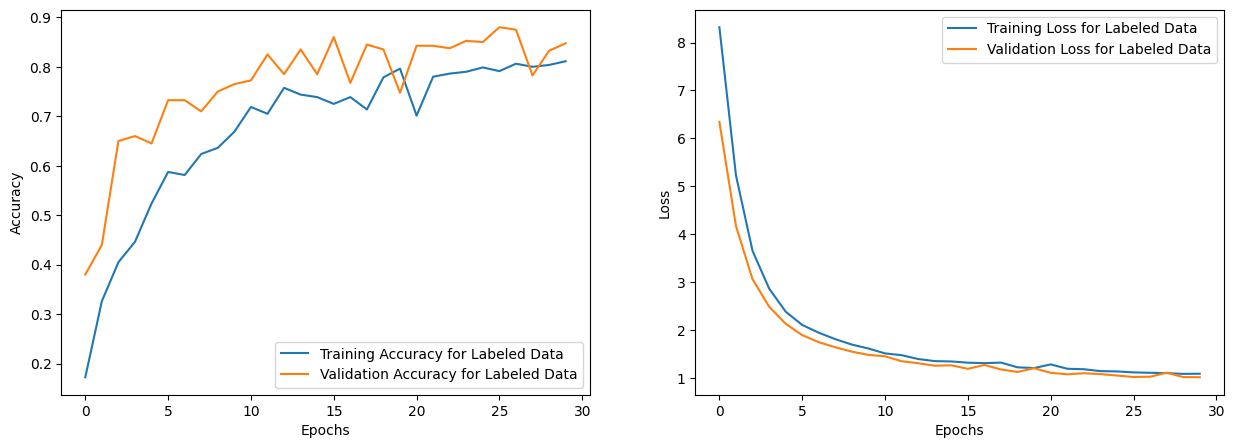

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_labeled.history["accuracy"], label="Training Accuracy for Labeled Data")
plt.plot(history_labeled.history["val_accuracy"], label="Validation Accuracy for Labeled Data")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_labeled.history["loss"], label="Training Loss for Labeled Data")
plt.plot(history_labeled.history["val_loss"], label="Validation Loss for Labeled Data")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


🔮 Generating Pseudo-Labels for Unlabeled Data...
✅ Generated 1098 pseudo-labels (confidence >= 0.7)
Found 1898 files belonging to 8 classes.
✅ Merged dataset created with 1898 images

🚀 Phase 2: Training on Merged Data (100 epochs)
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - accuracy: 0.9052 - loss: 0.8523 - val_accuracy: 0.8200 - val_loss: 0.9773 - learning_rate: 0.0010
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.8906 - loss: 0.8153 - val_accuracy: 0.7925 - val_loss: 0.9921 - learning_rate: 0.0010
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.8939 - loss: 0.7948 - val_accuracy: 0.7775 - val_loss: 0.9779 - learning_rate: 0.0010
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.9044 - loss: 0.7701 - val_accuracy: 0.8300 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.9111 - loss: 0.7448 - val_accuracy: 0.8450 - val_loss: 0.9012 - learning_rate: 0.00

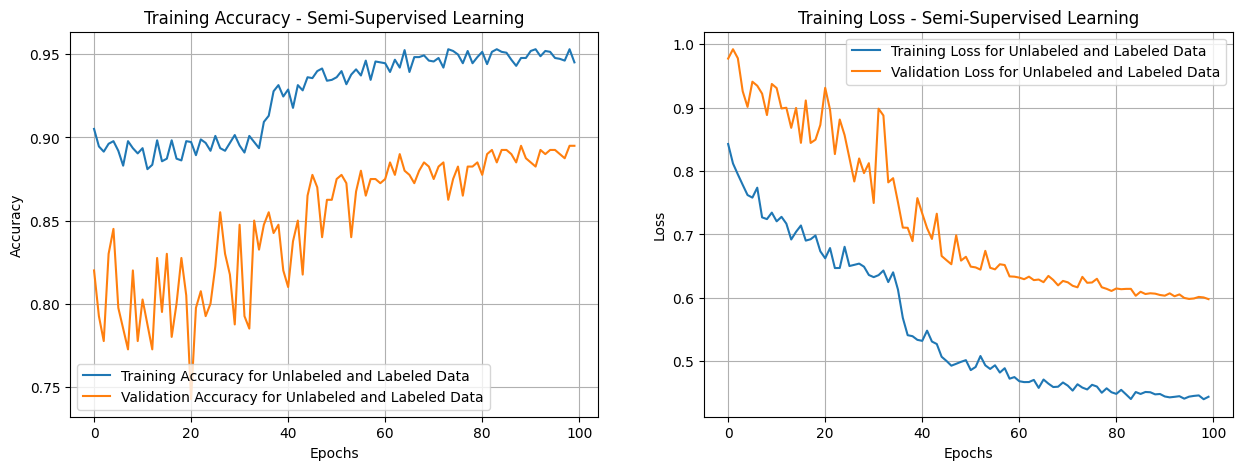


✅ After Labeled Training - Validation Accuracy: 87.75%


In [ ]:
"""# Step 7: Generate Pseudo-Labels for Unlabeled Data"""

print("\n🔮 Generating Pseudo-Labels for Unlabeled Data...")

# Create pseudo-labeled directory
pseudo_labeled_dir = '/content/semi_supervised_data/pseudo_labeled/'
for cls in classes:
    os.makedirs(os.path.join(pseudo_labeled_dir, cls), exist_ok=True)

# Generate pseudo-labels with confidence threshold
confidence_threshold = 0.7

def generate_pseudo_labels():
    pseudo_count = 0

    for cls in classes:
        class_path = os.path.join(unlabeled_dir, cls)
        images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)

            # Load and preprocess image
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            predictions = model.predict(img_array, verbose=0)
            confidence = np.max(predictions)
            predicted_class_idx = np.argmax(predictions)
            predicted_class = class_names[predicted_class_idx]

            # Only use high-confidence predictions
            if confidence >= confidence_threshold:
                dest_path = os.path.join(pseudo_labeled_dir, predicted_class, img_name)
                shutil.copy2(img_path, dest_path)
                pseudo_count += 1

    return pseudo_count

pseudo_count = generate_pseudo_labels()
print(f"✅ Generated {pseudo_count} pseudo-labels (confidence >= {confidence_threshold})")

"""# Step 8: Merge Labeled and Pseudo-Labeled Data"""

merged_dir = '/content/semi_supervised_data/merged/'
for cls in classes:
    os.makedirs(os.path.join(merged_dir, cls), exist_ok=True)

def merge_datasets():
    # Copy labeled data
    for cls in classes:
        labeled_path = os.path.join(labeled_dir, cls)
        images = os.listdir(labeled_path)
        for img in images:
            shutil.copy2(os.path.join(labeled_path, img),
                       os.path.join(merged_dir, cls, img))

    # Copy pseudo-labeled data
    for cls in classes:
        pseudo_path = os.path.join(pseudo_labeled_dir, cls)
        if os.path.exists(pseudo_path):
            images = os.listdir(pseudo_path)
            for img in images:
                shutil.copy2(os.path.join(pseudo_path, img),
                           os.path.join(merged_dir, cls, f"pseudo_{img}"))

merge_datasets()

# Load merged dataset
merged_dataset = image_dataset_from_directory(
    merged_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)
merged_dataset = merged_dataset.map(preprocess_data)

merged_count = sum([len(os.listdir(os.path.join(merged_dir, cls))) for cls in classes])
print(f"✅ Merged dataset created with {merged_count} images")

"""# Step 9: Train on Merged Data (100 Epochs)"""

print("\n🚀 Phase 2: Training on Merged Data (100 epochs)")

# Rebuild model or continue with existing
# Option 1: Continue with same model
# Option 2: Rebuild model (uncomment below)
# model = build_model()

history_merged = model.fit(
    merged_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)

"""# Step 10: Final Evaluation"""

test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n🎯 Final Test Accuracy: {test_acc * 100:.2f}%")

"""# Step 11: Plot Training History"""

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_merged.history["accuracy"], label="Training Accuracy for Unlabeled and Labeled Data")
plt.plot(history_merged.history["val_accuracy"], label="Validation Accuracy for Unlabeled and Labeled Data")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training Accuracy - Semi-Supervised Learning')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_merged.history["loss"], label="Training Loss for Unlabeled and Labeled Data")
plt.plot(history_merged.history["val_loss"], label="Validation Loss for Unlabeled and Labeled Data")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training Loss - Semi-Supervised Learning')
plt.legend()
plt.grid(True)
plt.show()
print(f"\n✅ After Labeled Training - Validation Accuracy: {test_acc * 100:.2f}%")

<Figure size 1200x1000 with 0 Axes>

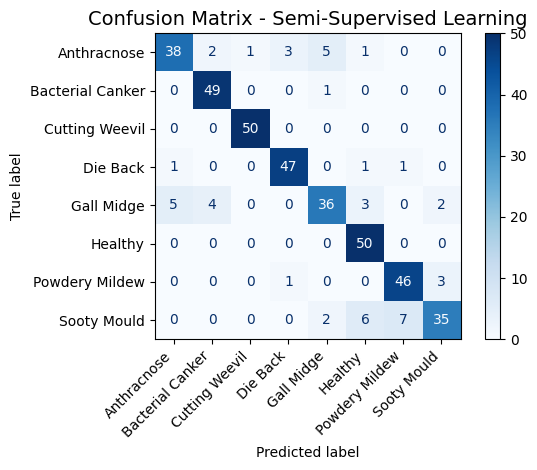

In [ ]:
"""# Step 12: Confusion Matrix"""

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Confusion Matrix - Semi-Supervised Learning", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Recover class names (if .class_names lost)
test_dir = os.path.join(base_dir, 'test')
class_names = sorted(os.listdir(test_dir))

# Collect true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Predict
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)

# Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step
Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.86      0.76      0.81        50
Bacterial Canker       0.89      0.98      0.93        50
  Cutting Weevil       0.98      1.00      0.99        50
        Die Back       0.92      0.94      0.93        50
      Gall Midge       0.82      0.72      0.77        50
         Healthy       0.82      1.00      0.90        50
  Powdery Mildew       0.85      0.92      0.88        50
     Sooty Mould       0.88      0.70      0.78        50

        accuracy                           0.88       400
       macro avg       0.88      0.88      0.87       400
    weighted avg       0.88      0.88      0.87       400

